In [1]:
import sys
sys.path.append("../")

from transformers import AutoTokenizer
from models.clip import CLIPTextTransformer, CLIPVisionTransformer, CLIPModel

In [98]:
import sys
sys.path.append("../")

from models.dataset_utils import make_dataloader, create_input_iter

# files = ['../data/tfrecords/observations_1.tfrecord','../data/tfrecords/observations_2.tfrecord','../data/tfrecords/observations_3.tfrecord','../data/tfrecords/observations_4.tfrecord',]
files = ['../data/observations.tfrecord',]
ds = make_dataloader(files, batch_size=32, seed=42)
create_input_iter(ds)

<generator object prefetch_to_device at 0x153a80630510>

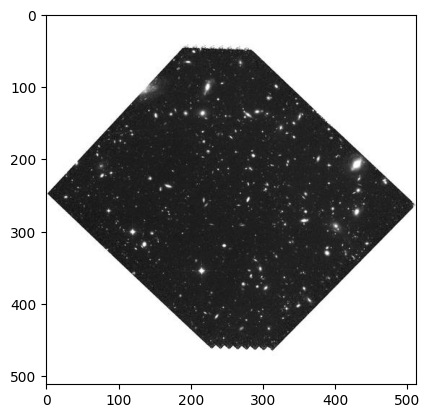

In [223]:
image, caption = next(iter(ds))

import matplotlib.pyplot as plt
plt.imshow(image[0], vmin=0, vmax=1)

In [224]:
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

caption = caption.numpy().tolist()
caption = [c.decode('utf-8') for c in caption]

txt_inputs = tokenizer(
                    caption,
                    padding="max_length",
                    truncation=True,
                    max_length=10,
                    return_tensors="np",
                )
txt_inputs = {k: txt_inputs[k] for k in ["input_ids", "attention_mask"]}

In [225]:
text_config = {
    "dtype": "float32",
    "activations": ["gelu"],
    "use_bias": False,
    "force_scale": False,
    "attention_dropout": 0.0,
    "mlp_dropout_rate": 0.0,
    "unroll": 100,
    "gradient_checkpointing": False,
    "eos_token_id": 49407,
    "vocab_size": 50000,
    "hidden_size": 512,
    "max_length": 300,
    "num_layers": 4,
    "use_rmsnorm": True,
    "ln_type": "normformer",
    "num_heads": 8,
    "position_embedding_type": "rotary",
    "use_causal_mask": False,
    "mlp_dim": 1024
  }

vision_config ={
  "position_embedding_type": "sincos2d",
  "dtype": "float32",
  "activations": ["gelu"],
  "use_bias": False,
  "force_scale": False,
  "attention_dropout": 0.0,
  "mlp_dropout_rate": 0.0,
  "unroll": 100,
  "gradient_checkpointing": True,
  "image_size": 512,
  "hidden_size": 512,
  "patch_size": 16,
  "num_layers": 4,
  "use_rmsnorm": True,
  "ln_type": "normformer",
  "num_heads": 4,
  "use_causal_mask": False,
  "mlp_dim": 1024
}

In [226]:
transformer = CLIPTextTransformer(**text_config)

In [227]:
import jax

key = jax.random.PRNGKey(0)
output, params = transformer.init_with_output(key, txt_inputs['input_ids'], txt_inputs['attention_mask'])

output['pooled_output']

Array([[ 0.20985875, -0.5216224 ,  0.2599633 , ...,  0.7824451 ,
         1.1156538 ,  1.3022372 ],
       [ 0.20985875, -0.5216224 ,  0.2599633 , ...,  0.7824451 ,
         1.1156538 ,  1.3022372 ],
       [ 0.20985875, -0.5216224 ,  0.2599633 , ...,  0.7824451 ,
         1.1156538 ,  1.3022372 ],
       ...,
       [ 0.20985875, -0.5216224 ,  0.2599633 , ...,  0.7824451 ,
         1.1156538 ,  1.3022372 ],
       [ 0.20985875, -0.5216224 ,  0.2599633 , ...,  0.7824451 ,
         1.1156538 ,  1.3022372 ],
       [ 0.20985875, -0.5216224 ,  0.2599633 , ...,  0.7824451 ,
         1.1156538 ,  1.3022372 ]], dtype=float32)

In [228]:
vit = CLIPVisionTransformer(**vision_config)

In [229]:
from PIL import Image
import jax.numpy as np
import matplotlib.pyplot as plt

outputs, params = vit.init_with_output(key, image.numpy());

In [230]:
num_local_devices = jax.local_device_count()

batch = {"pixel_values": image.numpy(), "input_ids": txt_inputs['input_ids'], "attention_mask": txt_inputs['attention_mask']}
batch = jax.tree_map(lambda x: np.array(x, dtype=np.float32), batch)
batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), batch)

In [231]:
clip = CLIPModel(text_config=text_config, vision_config=vision_config, projection_dim=256)

outputs, params = clip.init_with_output(key, np.array(batch["input_ids"])[0], np.array(batch["pixel_values"])[0], np.array(batch["attention_mask"])[0])

In [252]:
import jax
import jax.numpy as np

# Enable float64 for numerical stability
jax.config.update("jax_enable_x64", True)

def mini_batch_sigmoid_loss(text_embeds, image_embeds, logit_scale, logit_bias, negative_samples):
        """Positive samples are on the diagonal"""
        bs = text_embeds.shape[0]
        if negative_samples:
            labels = -np.ones((bs, bs))
        else:
            labels = 2 * np.eye(bs) - np.ones((bs, bs))
        logits = np.matmul(text_embeds, image_embeds.T) * logit_scale + logit_bias
    
        # Increase precision for large batches
        logits = logits.astype(np.float64)
        return -np.mean(jax.nn.log_sigmoid(labels * logits))

def sigmoid_loss(outputs):
        text_embeds = outputs["text_embeds"]
        image_embeds = outputs["image_embeds"]
        logit_scale = outputs["logit_scale"]
        logit_bias = outputs["logit_bias"]

        axis_size = jax.lax.psum(1, axis_name="batch")
    
        # Calculate local device loss
        loss = mini_batch_sigmoid_loss(text_embeds, image_embeds, logit_scale, logit_bias, negative_samples=False)

        # Add negative losses
        def add_negative_loss(i, carrys):
            cumul_loss, image_embeds = carrys
            
            # Shift image_embeds
            image_embeds = jax.lax.ppermute(
                image_embeds, axis_name="batch", perm=[(j, (j - 1) % axis_size) for j in range(axis_size)]
            )
            # Add loss (all negative samples)
            cumul_loss += mini_batch_sigmoid_loss(
                text_embeds, image_embeds, logit_scale, logit_bias, negative_samples=True
            )
            
            return cumul_loss, image_embeds

        loss, _ = jax.lax.fori_loop(0, axis_size - 1, add_negative_loss, (loss, image_embeds))
        loss = loss / axis_size

        loss = loss.reshape((-1,))

        # Average loss across devices
        loss = np.mean(loss)
        return loss

In [253]:
def retrieval_eval_metric(outputs, k=[1, 5, 10]):
    text_embeds = outputs["text_embeds"]
    image_embeds = outputs["image_embeds"]
    logit_scale = outputs["logit_scale"]
    logit_bias = outputs["logit_bias"]

    # Get shapes
    bs = text_embeds.shape[0]
    axis_size = jax.lax.psum(1, axis_name="batch")

    # Gather the embeddings from all devices
    all_text_embeds = jax.lax.all_gather(text_embeds, axis_name="batch").reshape(-1, text_embeds.shape[-1])
    all_image_embeds = jax.lax.all_gather(image_embeds, axis_name="batch").reshape(-1, image_embeds.shape[-1])

    # Compute the full matrix of logitseval
    all_logits = np.matmul(all_text_embeds, all_image_embeds.T) * logit_scale + logit_bias

    # Compute the global top-k indices for the maximum k value
    max_k = max(k)
    top_k_indices = np.argsort(all_logits, axis=-1)[:, -max_k:]

    # Compute the correct indices for each row
    correct_indices = np.arange(bs * axis_size)[:, None]

    metrics = {}
    for current_k in k:
        # Check if the correct image (diagonal) is in the current top-k for each text embedding
        correct_in_top_k = np.any(top_k_indices[:, -current_k:] == correct_indices, axis=-1)
        accuracy = np.mean(correct_in_top_k.astype(np.float32))
        metrics[f"top_{current_k}_accuracy"] = accuracy

    return metrics

In [262]:
from functools import partial

@partial(jax.pmap, axis_name="batch")
def eval_step(state, input_ids, images, attention_mask):
    """Train for a single step."""

    def loss_fn(params):
        outputs = state.apply_fn(params, input_ids, images, attention_mask)
        loss = sigmoid_loss(outputs)
        retrieval_metrics = retrieval_eval_metric(outputs)
        return loss, retrieval_metrics

    loss, retrieval_metrics = loss_fn(state.params)
    
    metrics = {"loss": jax.lax.pmean(loss, "batch")}
    for key, value in retrieval_metrics.items():
        metrics[key] = jax.lax.pmean(value, "batch")

    return metrics

In [263]:
import optax 
from flax.training import checkpoints, common_utils, train_state

import flax

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

tx = optax.adamw(learning_rate=1e-4)
state = train_state.TrainState.create(apply_fn=clip.apply, params=params, tx=tx)
pstate = replicate(state)

metrics = eval_step(pstate, np.array(batch["input_ids"]), np.array(batch["pixel_values"]), np.array(batch["attention_mask"]))

In [264]:
metrics

{'loss': Array([0.80493089, 0.80493089, 0.80493089, 0.80493089], dtype=float64),
 'top_10_accuracy': Array([0.3125, 0.3125, 0.3125, 0.3125], dtype=float32),
 'top_1_accuracy': Array([0.03125, 0.03125, 0.03125, 0.03125], dtype=float32),
 'top_5_accuracy': Array([0.15625, 0.15625, 0.15625, 0.15625], dtype=float32)}

In [265]:
outputs, params = clip.init_with_output(key, np.array(batch["input_ids"]).reshape((32, -1)), np.array(batch["pixel_values"]).reshape(32, 512, 512, 3), np.array(batch["attention_mask"]).reshape(32, -1))

In [266]:
text_embeds = outputs["text_embeds"]
image_embeds = outputs["image_embeds"]

logits = np.matmul(text_embeds, image_embeds.T)

k = [1, 5, 10, 29]

# Compute the global top-k indices for the maximum k value
max_k = max(k)
top_k_indices = np.argsort(logits, axis=-1)[:, -max_k:]

correct_indices = np.arange(text_embeds.shape[0])[:, None]

metrics = {}
for current_k in k:
    # Check if the correct image (diagonal) is in the current top-k for each text embedding
    correct_in_top_k = np.any(top_k_indices[:, -current_k:] == correct_indices, axis=-1)
    accuracy = np.mean(correct_in_top_k.astype(np.float32))
    metrics[f"top_{current_k}_accuracy"] = accuracy

metrics

{'top_1_accuracy': Array(0.03125, dtype=float32),
 'top_5_accuracy': Array(0.15625, dtype=float32),
 'top_10_accuracy': Array(0.3125, dtype=float32),
 'top_29_accuracy': Array(0.90625, dtype=float32)}